In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import matplotlib.pyplot as plt
!pip install pmdarima -q
from pmdarima.arima import auto_arima

In [2]:
df_income = pd.read_csv('/content/Income_Statement_quarterly.csv')
df_income['date'].astype('datetime64[ns]')
df_income.sort_values(by=['symbol', 'date'], inplace=True)
df_income = df_income[df_income['symbol'].map(df_income['symbol'].value_counts()) == 20]
df_income.head()

,symbol,date,filing_date,currency_symbol,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,...,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments
2079,A,2017-10-31,2017-12-21,USD,89000000.0,0.0,226000000.0,-5000000.0,177000000.0,325000000.0,...,0.0,49000000.0,1.189000e+09,414000000.0,542000000.0,-7000000.0,0.0,177000000.0,177000000.0,NaN
2078,A,2018-01-31,2018-03-06,USD,93000000.0,0.0,233000000.0,4000000.0,-320000000.0,341000000.0,...,0.0,553000000.0,1.211000e+09,434000000.0,538000000.0,-6000000.0,0.0,-320000000.0,-320000000.0,NaN
2077,A,2018-04-30,2018-05-31,USD,91000000.0,0.0,227000000.0,4000000.0,205000000.0,338000000.0,...,0.0,22000000.0,1.206000e+09,429000000.0,562000000.0,12000000.0,0.0,205000000.0,205000000.0,NaN
2076,A,2018-07-31,2018-08-30,USD,97000000.0,0.0,242000000.0,4000000.0,236000000.0,339000000.0,...,0.0,6000000.0,1.203000e+09,436000000.0,542000000.0,17000000.0,0.0,236000000.0,236000000.0,NaN
2075,A,2018-10-31,2018-12-20,USD,104000000.0,0.0,244000000.0,4000000.0,195000000.0,356000000.0,...,0.0,49000000.0,1.294000e+09,460000000.0,585000000.0,-5000000.0,0.0,195000000.0,195000000.0,NaN


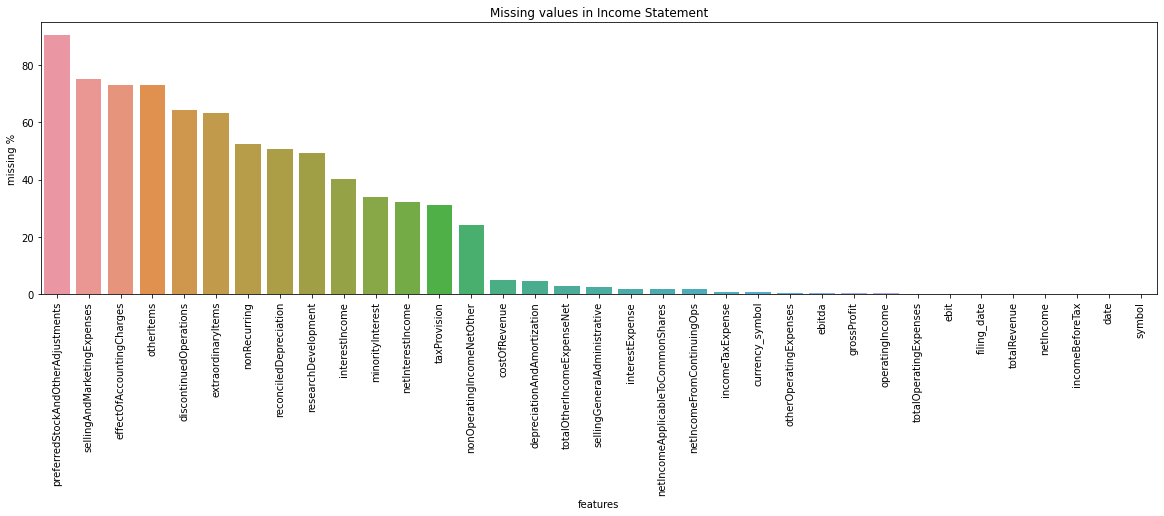

In [3]:
# plot missing %
df_col_na = np.mean(100 * df_income.isna()).to_frame().reset_index()
df_col_na.columns = ['features', 'missing %']
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.barplot(data=df_col_na.sort_values(by=['missing %'], ascending=False), x='features', y='missing %', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Missing values in Income Statement')
plt.show()

In [4]:
# train ARIMA model by atuomatically search the optimal hyperparameters
symbols = df_income['symbol'].unique().tolist()

result = {}
for symbol in symbols:
    df_ebit = df_income[df_income['symbol'] == symbol][['date', 'ebit']]
    if df_ebit.isnull().values.any() or symbol in ['AOS', 'FFIV', 'WEC']: continue

    df_ebit.set_index('date', inplace=True)
    model = auto_arima(df_ebit, m=4)
    model.fit(df_ebit.head(16))
    pred = model.predict(n_periods=4).to_frame(name='ebit')
    pred.index.rename('date', inplace=True)
    pred.index = pred.index.astype(str)
    result[symbol] = (model, pred)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is availa

In [6]:
df_AIZ_ebit = df_income[df_income['symbol'] == symbols[0]][['date', 'ebit']]
df_AIZ_ebit.set_index('date', inplace=True)
stepwise_model = auto_arima(df_AIZ_ebit, m=4)
train = df_AIZ_ebit.head(16)
test = df_AIZ_ebit.tail(4)
stepwise_model.fit(train)
pred = stepwise_model.predict(n_periods=4).to_frame(name='ebit')
pred.index.rename('date', inplace=True)
pred.index = pred.index.astype(str)

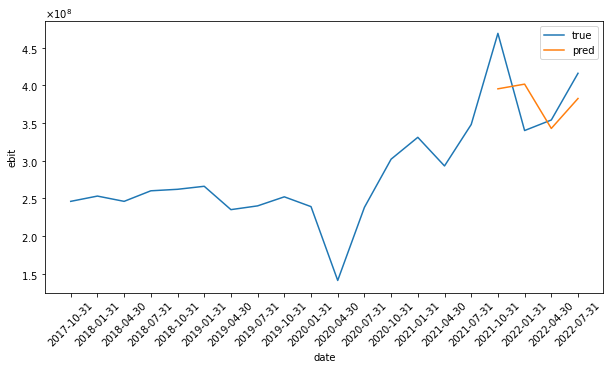

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.ticklabel_format(axis='y', scilimits=(0, 0), useMathText=True)
sns.lineplot(data=df_AIZ_ebit, x='date', y='ebit', label='true', ax=ax)
sns.lineplot(data=pred, x='date', y='ebit', label='pred', ax=ax)
plt.xticks(rotation=45)
plt.show()

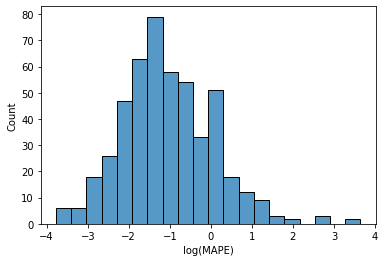

In [5]:
# Performance evaluation

def MAPE(y_pred, y_act): return np.mean(np.abs((y_act - y_pred) / y_act))

mape = []
for symbol in result:
    y_act = df_income[df_income['symbol'] == symbol].tail(4)['ebit'].to_numpy()
    y_pred = result[symbol][1]['ebit'].to_numpy()
    mape.append(MAPE(y_pred, y_act))
sns.histplot(data=np.log(mape))
plt.xlabel('log(MAPE)')
plt.show()
